In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import time
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing, model_selection, pipeline
from sklearn.metrics import f1_score, roc_auc_score
from pathlib import Path
import sys


In [2]:
BASE_DIR = str(Path().cwd().parent.resolve())
sys.path.insert(0, BASE_DIR)

In [3]:
df = pd.read_csv(f'{BASE_DIR}/data/fake_job_postings.csv', engine = 'python')
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
textdf = df.iloc[:, [1,5,6,7,8,17]]
textdf = textdf.fillna('None')
textdf.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,None,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,None,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [14]:
def clean_text(text):
    text = text.lower()
    
    text = text.replace(r'&amp;', '&')
    text = text.replace(r'&nbsp;', ' ')
    text = text.replace(r'&lt;', '<')
    text = text.replace(r'&gt;', '>')
    text = text.replace(r'&quot;', '"')
    text = text.replace(r'\u00a0', ' ')
    
    text = re.sub('\'re', ' are', text)
    text = re.sub('\'ve', ' have', text)
    text = re.sub('\'m', ' am', text)
    text = re.sub('\'t', ' not', text)
    
    sublist = '\[.*?\]|https?://\S+|www\.\S+|<.*?>+|\n|\w*\d\w*'
    text = re.sub(sublist, '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    return text

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
text_cleaned = textdf.copy(deep = True)

for col in text_cleaned.columns[:-1]:
    text_cleaned[col] = text_cleaned[col].astype(str).apply(lambda x : clean_text(x))
    
text_cleaned.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,marketing intern,we are and we have created a groundbreaking a...,a fastgrowing james beard awardwinning online...,experience with content management systems a m...,none,0
1,customer service cloud video production,seconds the worlds cloud video production ser...,organised focused vibrant awesomedo you hav...,what we expect from youyour key responsibility...,what you will get from usthrough being part of...,0
2,commissioning machinery assistant cma,valor services provides workforce solutions th...,our client located in houston is actively seek...,implement precommissioning and commissioning p...,none,0
3,account executive washington dc,our passion for improving quality of life thro...,the company esri – environmental systems resea...,education bachelor’s or master’s in gis busine...,our culture is anything but corporate—we have ...,0
4,bill review manager,spotsource solutions llc is a global human cap...,job title itemization review managerlocation f...,qualificationsrn license in the state of texas...,full benefits offered,0


In [17]:
text_tokenized = text_cleaned.copy(deep = True)

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

for col in text_tokenized.columns[:-1]:
    text_tokenized[col] = text_tokenized[col].apply(lambda x : tokenizer.tokenize(x))

text_tokenized.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,"[marketing, intern]","[we, are, and, we, have, created, a, groundbre...","[a, fastgrowing, james, beard, awardwinning, o...","[experience, with, content, management, system...",[none],0
1,"[customer, service, cloud, video, production]","[seconds, the, worlds, cloud, video, productio...","[organised, focused, vibrant, awesomedo, you, ...","[what, we, expect, from, youyour, key, respons...","[what, you, will, get, from, usthrough, being,...",0
2,"[commissioning, machinery, assistant, cma]","[valor, services, provides, workforce, solutio...","[our, client, located, in, houston, is, active...","[implement, precommissioning, and, commissioni...",[none],0
3,"[account, executive, washington, dc]","[our, passion, for, improving, quality, of, li...","[the, company, esri, environmental, systems, r...","[education, bachelor, s, or, master, s, in, gi...","[our, culture, is, anything, but, corporate, w...",0
4,"[bill, review, manager]","[spotsource, solutions, llc, is, a, global, hu...","[job, title, itemization, review, managerlocat...","[qualificationsrn, license, in, the, state, of...","[full, benefits, offered]",0


In [18]:
text_lemmatized = text_tokenized.copy(deep = True)

wl = WordNetLemmatizer()
stop_words = stopwords.words('english')

for col in text_lemmatized.columns[:-1]:
    text_lemmatized[col] = text_lemmatized[col].apply(lambda x : [wl.lemmatize(w) for w in x if w not in stop_words])

text_lemmatized.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,"[marketing, intern]","[created, groundbreaking, awardwinning, cookin...","[fastgrowing, james, beard, awardwinning, onli...","[experience, content, management, system, majo...",[none],0
1,"[customer, service, cloud, video, production]","[second, world, cloud, video, production, serv...","[organised, focused, vibrant, awesomedo, passi...","[expect, youyour, key, responsibility, communi...","[get, usthrough, part, second, team, gainexper...",0
2,"[commissioning, machinery, assistant, cma]","[valor, service, provides, workforce, solution...","[client, located, houston, actively, seeking, ...","[implement, precommissioning, commissioning, p...",[none],0
3,"[account, executive, washington, dc]","[passion, improving, quality, life, geography,...","[company, esri, environmental, system, researc...","[education, bachelor, master, gi, business, ad...","[culture, anything, corporate, collaborative, ...",0
4,"[bill, review, manager]","[spotsource, solution, llc, global, human, cap...","[job, title, itemization, review, managerlocat...","[qualificationsrn, license, state, texasdiplom...","[full, benefit, offered]",0


In [19]:
text_df = text_lemmatized.copy(deep = True)

for col in text_df.columns[:-1]:
    text_df[col] = text_df[col].apply(lambda x : ' '.join(x))
    
text_df.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,marketing intern,created groundbreaking awardwinning cooking si...,fastgrowing james beard awardwinning online fo...,experience content management system major plu...,none,0
1,customer service cloud video production,second world cloud video production service se...,organised focused vibrant awesomedo passion cu...,expect youyour key responsibility communicate ...,get usthrough part second team gainexperience ...,0
2,commissioning machinery assistant cma,valor service provides workforce solution meet...,client located houston actively seeking experi...,implement precommissioning commissioning proce...,none,0
3,account executive washington dc,passion improving quality life geography heart...,company esri environmental system research ins...,education bachelor master gi business administ...,culture anything corporate collaborative creat...,0
4,bill review manager,spotsource solution llc global human capital m...,job title itemization review managerlocation f...,qualificationsrn license state texasdiploma ba...,full benefit offered,0


In [20]:
def get_top_tweet_Ngrams(corpus, size, n=None):
    vec = CountVectorizer(ngram_range=(size, size)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def top_common_tweet(col, size, n):
    top_ngrams_Real = get_top_tweet_Ngrams(text_df[col][text_df.fraudulent == 0], size)[:n]
    top_ngrams_Fake = get_top_tweet_Ngrams(text_df[col][text_df.fraudulent == 1], size)[:n]

    words_R, counts_R = map(list, zip(*top_ngrams_Real))
    words_F, counts_F = map(list, zip(*top_ngrams_Fake))

    return list(set(words_R).intersection(words_F))

def top_diff_tweet(col, size, n, REAL = True):
    top_ngrams_Real = get_top_tweet_Ngrams(text_df[col][text_df.fraudulent == 0], size)[:n]
    top_ngrams_Fake = get_top_tweet_Ngrams(text_df[col][text_df.fraudulent == 1], size)[:n]

    words_R, counts_R = map(list, zip(*top_ngrams_Real))
    words_F, counts_F = map(list, zip(*top_ngrams_Fake))
    
    if REAL:
        comp = list(set(words_R) - set(words_F))
    else:
        comp = list(set(words_F) - set(words_R))
    
    return comp

In [21]:
Nsize = 2
topk = 20

for col in text_df.columns[:-1]:
    print('top {} {}-grams in {} only in Real'.format(topk, Nsize, col))
    print(top_diff_tweet(col, Nsize, topk, True))

top 20 2-grams in title only in Real
['year old', 'front end', 'account executive', 'teacher abroad', 'abroad conversational', 'business development', 'graduate english', 'web developer', 'na year', 'english teacher', 'sale manager', 'project manager', 'account manager', 'marketing manager', 'software engineer', 'service associate', 'apprenticeship na', 'sale representative']
top 20 2-grams in company_profile only in Real
['high quality', 'safe secure', 'around world', 'full time', 'get safe', 'secure job', 'customer satisfaction', 'increase productivity', 'new york', 'teacher get', 'document communication', 'medium large', 'business process', 'valor service', 'job abroad', 'provide full', 'large company', 'quality candidate', 'help teacher', 'solution help']
top 20 2-grams in description only in Real
['join team', 'usd monthly', 'year experience', 'right candidate', 'business development', 'social medium', 'student loanscredit', 'level customer', 'work closely', 'monthly cost', 'ideal

In [22]:
Nsize = 2
topk = 20

for col in text_df.columns[:-1]:
    print('top {} {}-grams in {} only in Fake'.format(topk, Nsize, col))
    print(top_diff_tweet(col, Nsize, topk, False))

top 20 2-grams in title only in Fake
['staff wanted', 'work home', 'wanted urgent', 'position earn', 'home based', 'clerk position', 'entry adminclerical', 'position work', 'earn daily', 'payroll data', 'payroll typistdata', 'adminclerical position', 'cruise staff', 'administrative assistant', 'data entry', 'service representative', 'based payroll', 'entry clerk']
top 20 2-grams in company_profile only in Fake
['compensation package', 'candidate enjoy', 'year access', 'referral bonus', 'encouraged participate', 'candidate encouraged', 'process provide', 'staffing solution', 'bonus program', 'hiring process', 'aptitude staffing', 'participate referral', 'service town', 'real estate', 'partnered effort', 'streamline hiring', 'employee receive', 'signing bonus', 'refined resource', 'effort streamline']
top 20 2-grams in description only in Fake
['ultra luxury', 'oil gas', 'work home', 'design technology', 'service oil', 'aker solution', 'product system', 'provider product', 'project manag

In [31]:
def plot_top_Ngrams(col, size, Real = True, n = 20):
    
    if Real:
        top_ngrams = get_top_tweet_Ngrams(text_df[col][text_df.fraudulent == 0], size)[:n]
    else:
        top_ngrams = get_top_tweet_Ngrams(text_df[col][text_df.fraudulent == 1], size)[:n]
    
    words, counts = map(list, zip(*top_ngrams))
    #none 제거
    for i in range(words.count('none')):
        idx = words.index('none')
        del words[idx]
        del counts[idx]
    
    fig = plt.figure(figsize = (10, n))
    sns.barplot(x = counts, y = words)
    plt.title('top {}-grams of {} in {}'.format(size, col, 'Real' if Real else 'Fake'))
    plt.show()

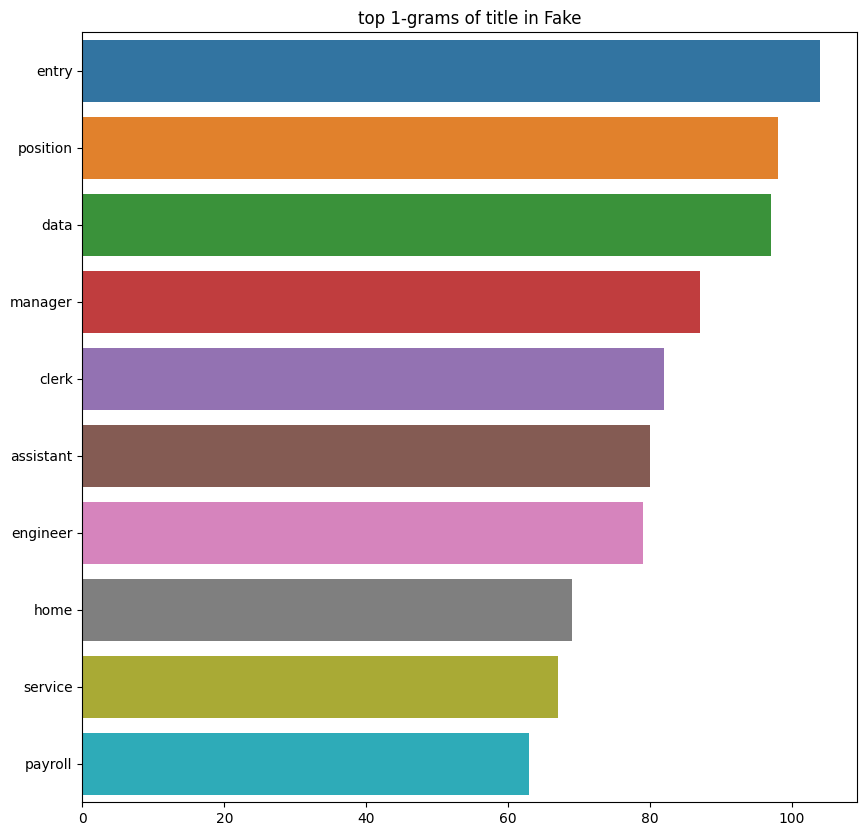

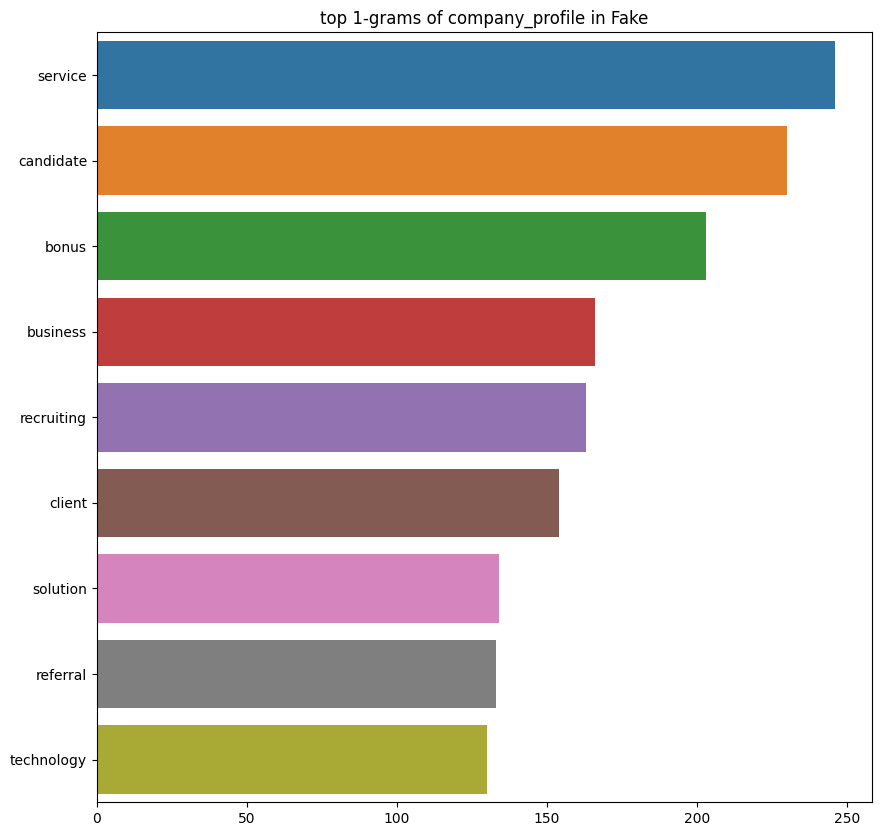

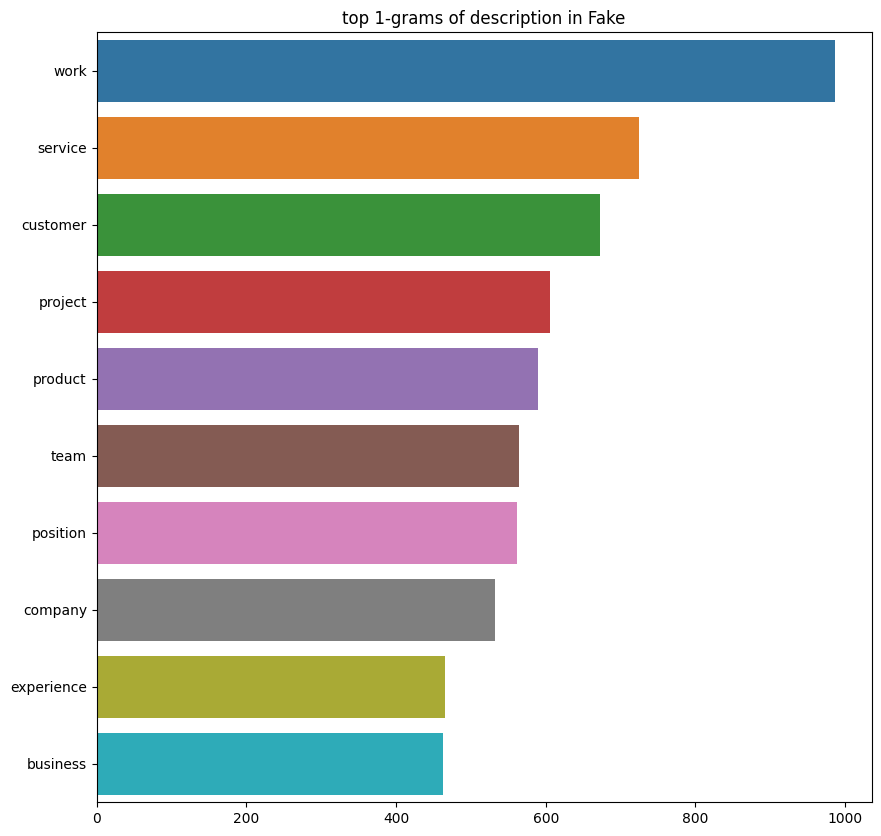

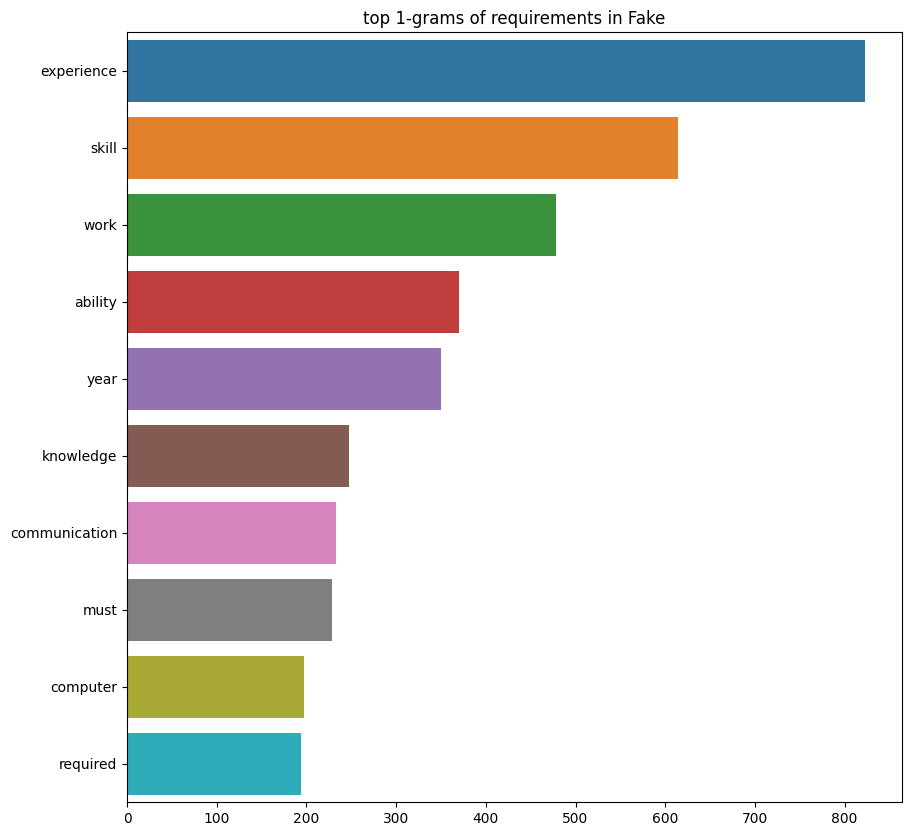

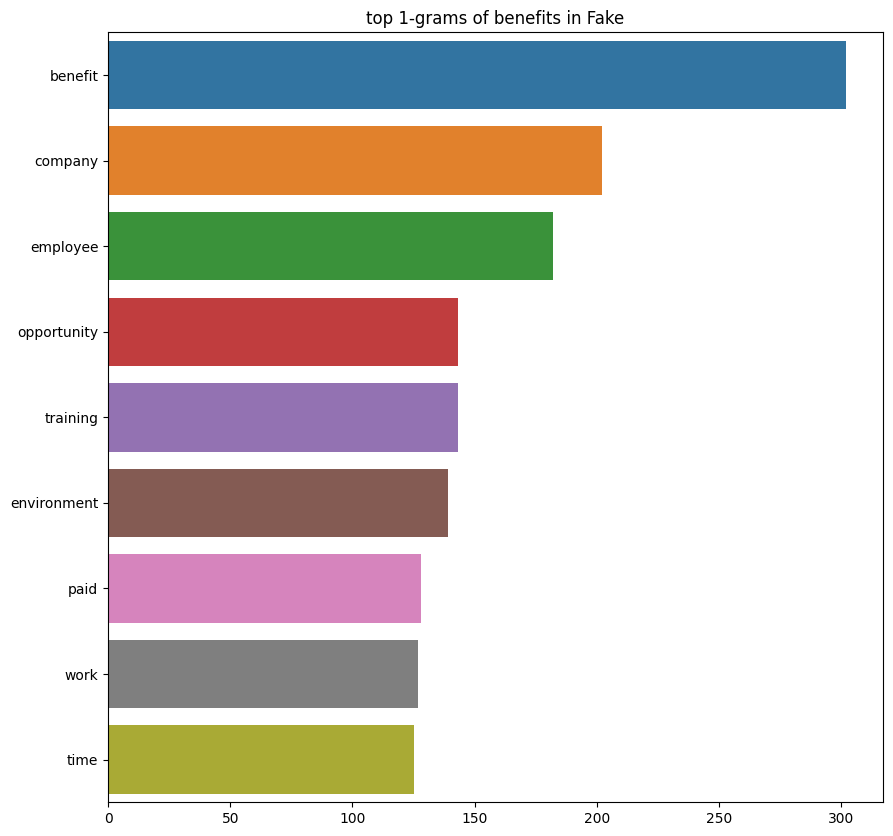

In [32]:
for col in text_df.columns[:-1]:
    plot_top_Ngrams(col, 1, False, n = 10)

In [45]:
# 주소 count 비교

Rcounts = []
for col in textdf.columns[:-1]:
    counts = 0
    for x in textdf[col][textdf.fraudulent == 0]:
        counts += len(re.findall('https?://\S+|www\.\S+', x))
    Rcounts.append(counts)

Fcounts = []
for col in textdf.columns[:-1]:
    counts = 0
    for x in textdf[col][textdf.fraudulent == 1]:
        counts += len(re.findall('https?://\S+|www\.\S+', x))
    Fcounts.append(counts)
    
print(Rcounts)
print(Fcounts)

[0, 180, 74, 1, 29]
[0, 0, 1, 0, 0]


In [51]:
from rake_nltk import Rake

DATA = text_cleaned

def get_keyword(text, length):
    r = Rake()
    r.extract_keywords_from_text(text)
    full_keyword = r.get_ranked_phrases()
    
    result = []
    for k in full_keyword:
        if len(k.split()) == length:
            result.append(k)
    return result

def keyword_list(col, length, topk, FAKE = True):
    keywords = []
    for x in DATA[col][DATA.fraudulent == FAKE]:
        kw = get_keyword(x, length)[:topk]
        for k in kw:
            keywords.append(k)
    result = pd.DataFrame(keywords)
    return result

def plot_keyword_counts(col, length, topk, plotsize = 10, FAKE = True):
    klist = keyword_list(col, length, topk, FAKE)[0]
    
    fig = plt.figure(figsize = (10, plotsize))
    ax = plt.subplot(1,1,1)
    sns.countplot(y = klist, order = klist.value_counts().iloc[:plotsize].index)
    plt.title('top-{} {} words keywords of {} in {}'.format(topk, length, col, 'Fake' if FAKE else 'Real'))
    plt.show()

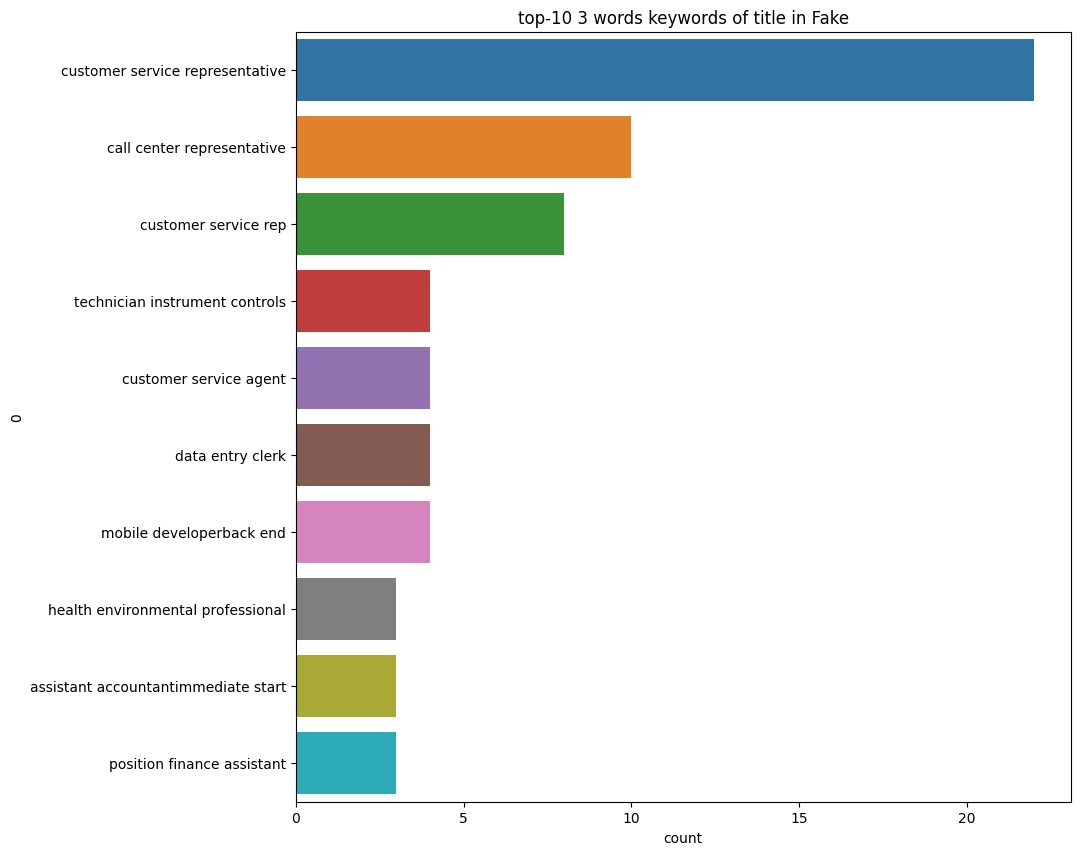

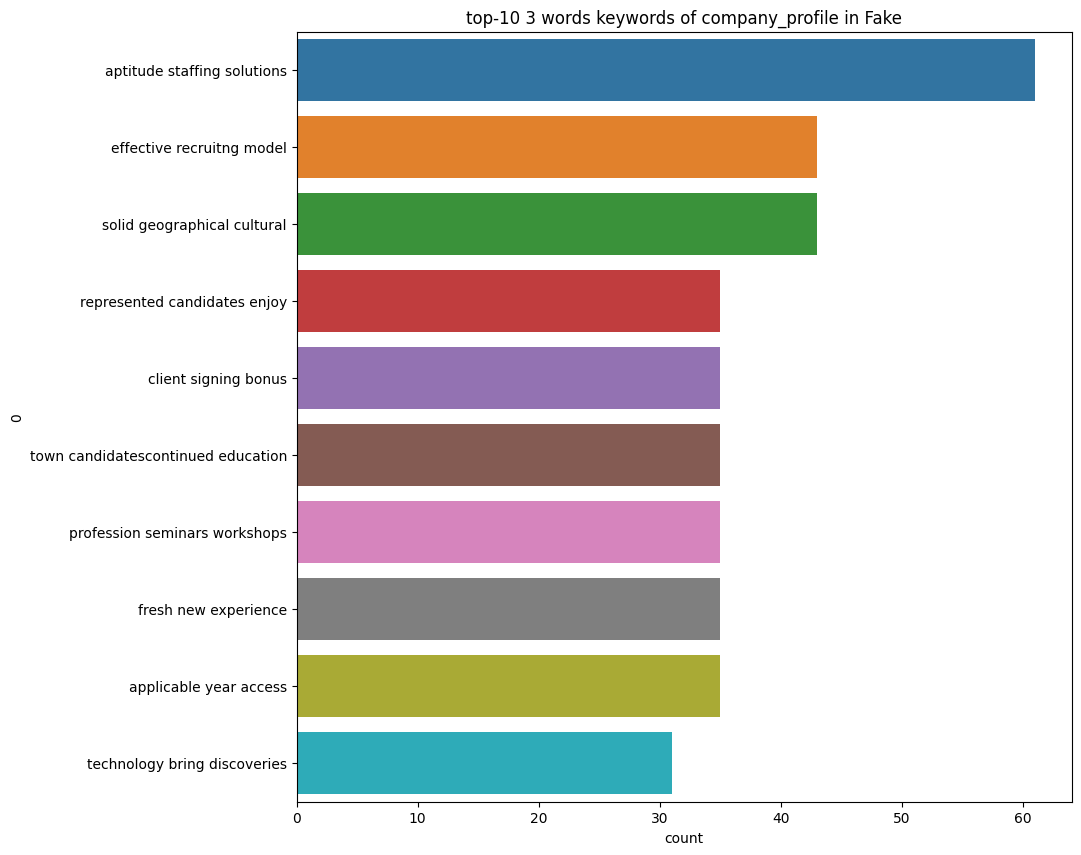

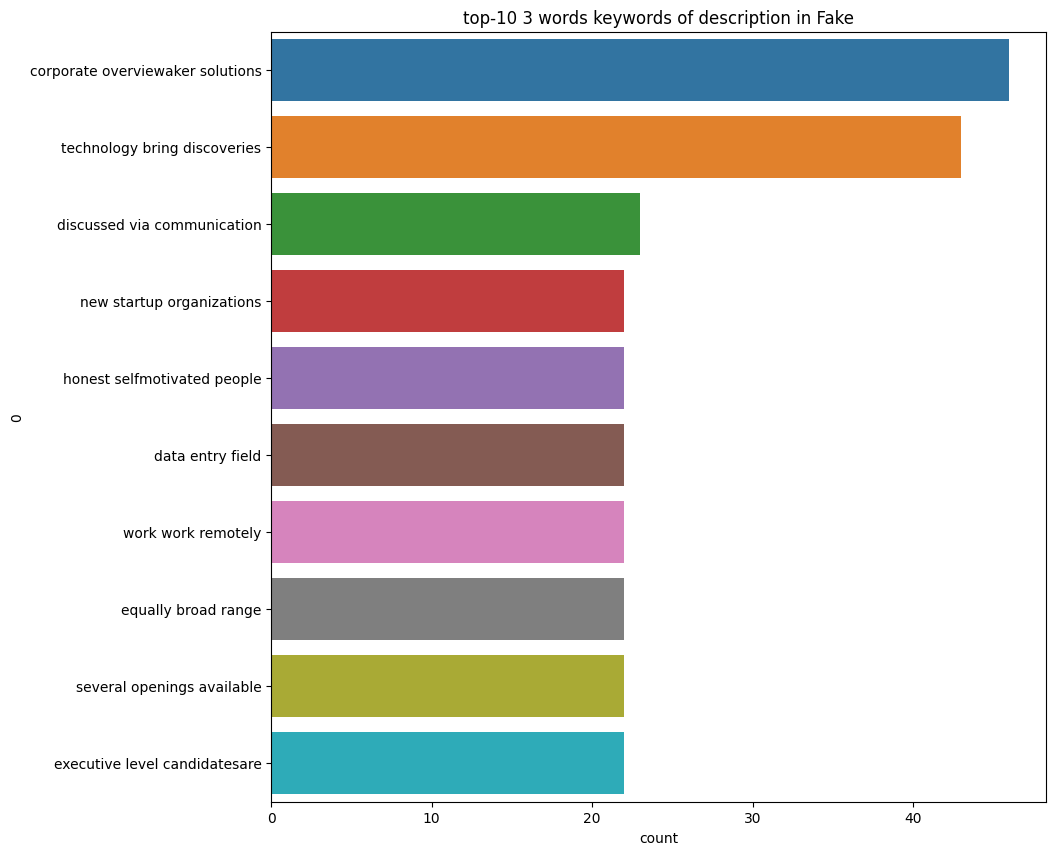

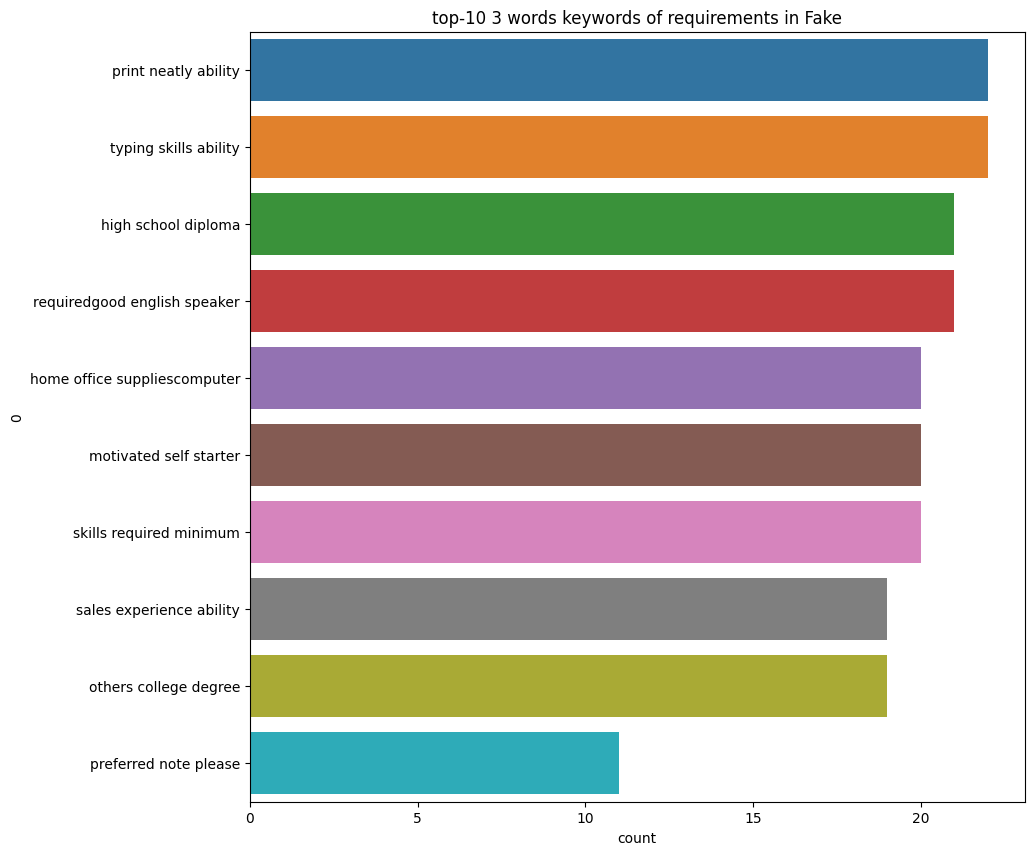

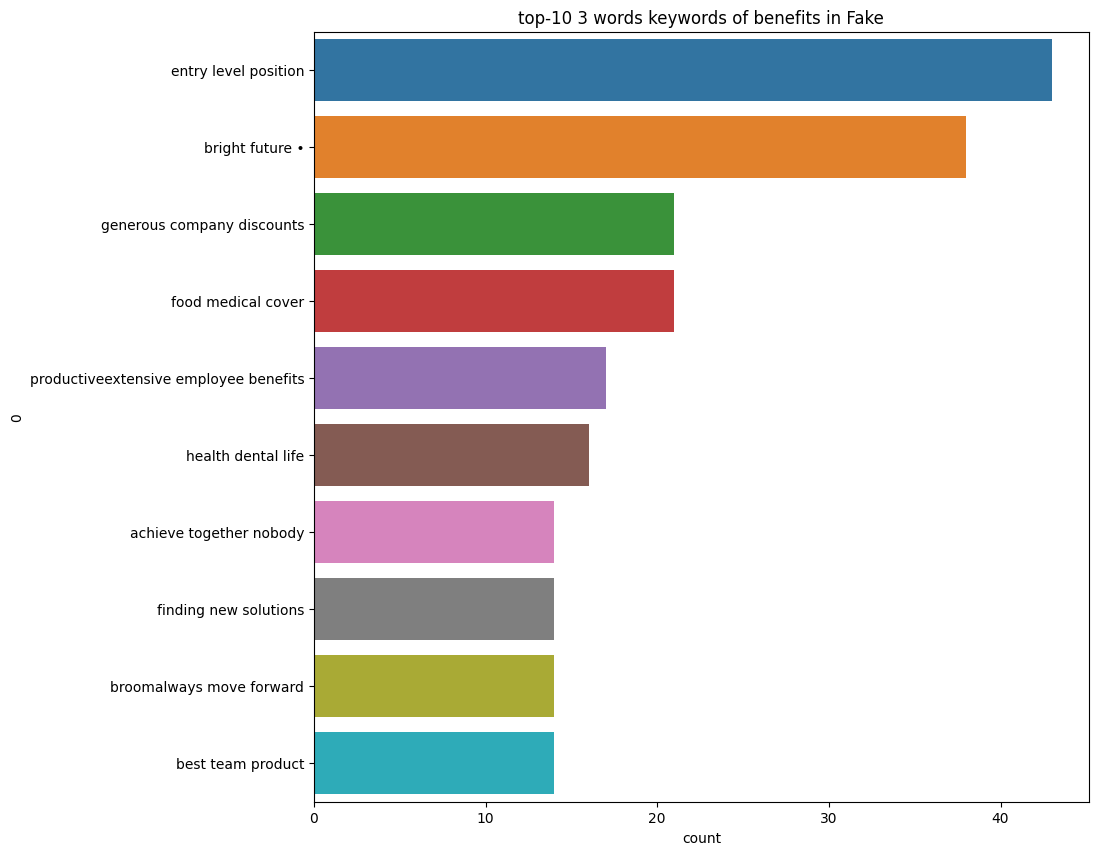

In [52]:
# plot_keyword_counts(col, 단어 길이, 한 text에서 추출할 keyword 개수, plot할 개수, Fake인지)


for col in DATA.columns[:-1]:
    plot_keyword_counts(col, 3, 10)

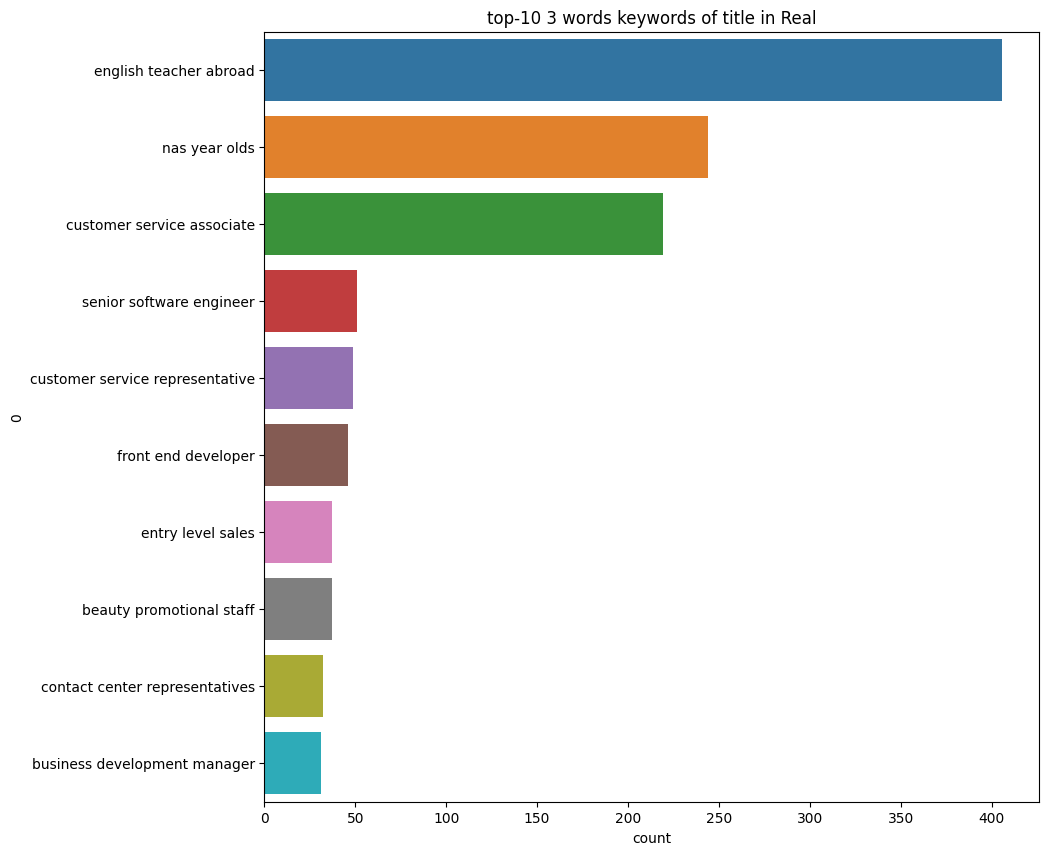

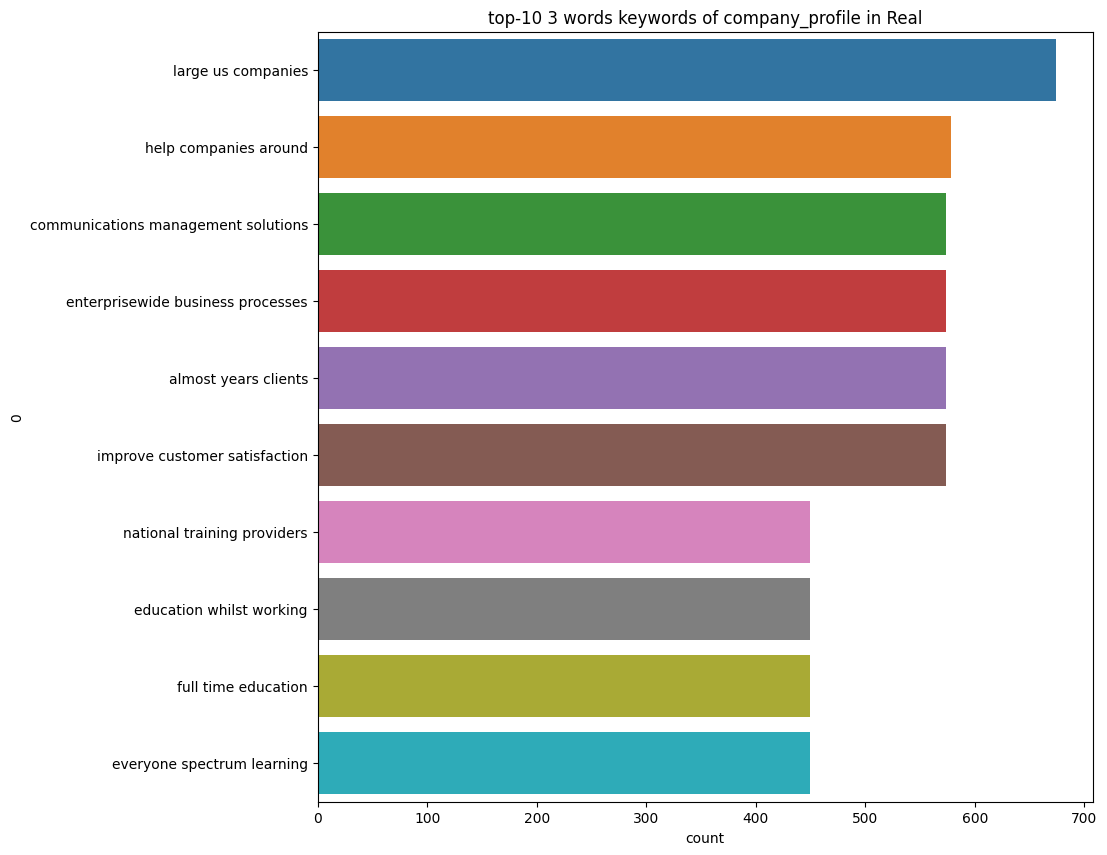

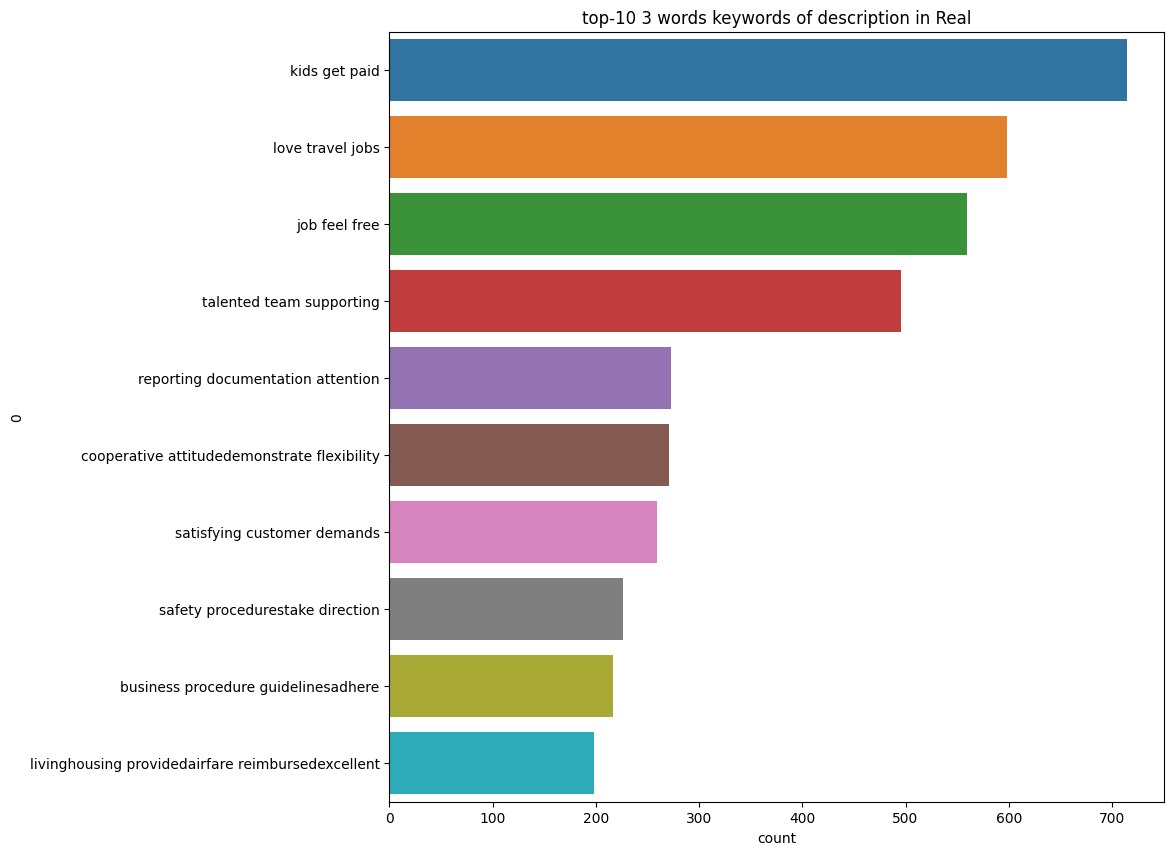

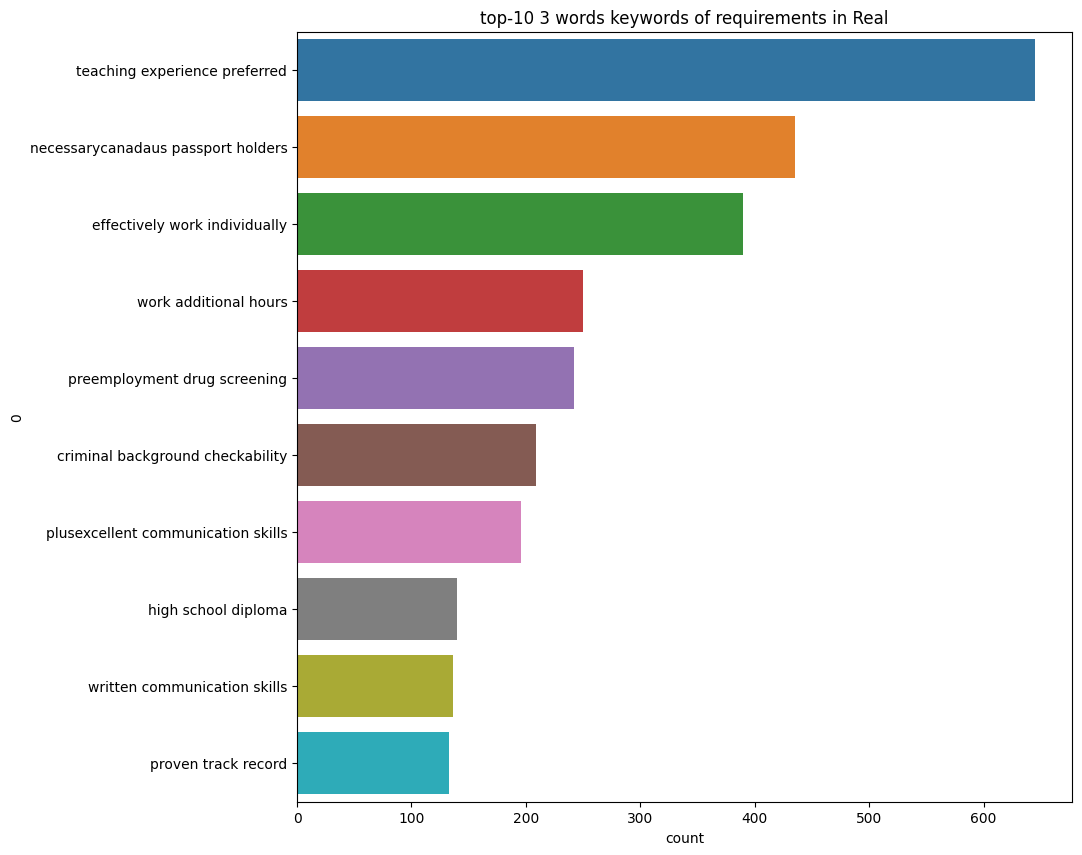

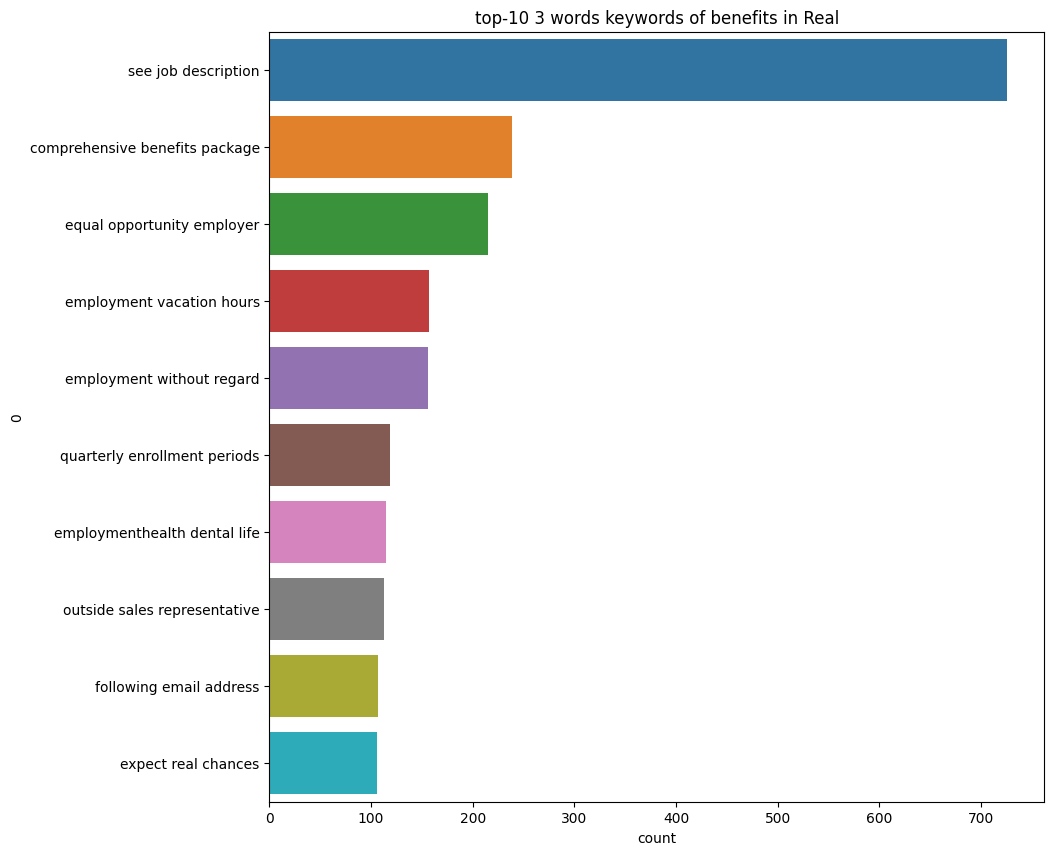

In [53]:
for col in DATA.columns[:-1]:
    plot_keyword_counts(col, 3, 10, FAKE = False)